In [3]:
import sys
import io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
import sqlite3
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import datetime as dt
from sklearn import linear_model
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
import json
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import openai
import pandas as pd
import sqlite3
from openai.api_resources.completion import Completion

In [4]:
# Connect to the sqlite db file and retrieve data as Pandas data frame.
cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')
sql = "select * from fires"
# df = pd.read_sql_query(sql, cnx)

In [5]:
df = pd.read_sql_query(sql, cnx)
df.head()
str(df.columns)

"Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape'], dtype='object')"

In [6]:
df_interest = df[["FIRE_YEAR","DISCOVERY_DOY","DISCOVERY_TIME","CONT_DOY","CONT_TIME","STAT_CAUSE_CODE","STAT_CAUSE_DESCR","FIRE_SIZE","LATITUDE","LONGITUDE","STATE","COUNTY","FIPS_NAME","DISCOVERY_DATE"]]
df_interest.isna().sum()

FIRE_YEAR                0
DISCOVERY_DOY            0
DISCOVERY_TIME      882638
CONT_DOY            891531
CONT_TIME           972173
STAT_CAUSE_CODE          0
STAT_CAUSE_DESCR         0
FIRE_SIZE                0
LATITUDE                 0
LONGITUDE                0
STATE                    0
COUNTY              678148
FIPS_NAME           678148
DISCOVERY_DATE           0
dtype: int64

In [7]:
print(f"Number of removed duplicate rows: {df_interest.duplicated().sum()}")
df_interest = df_interest.drop_duplicates()

Number of removed duplicate rows: 3525


In [8]:
df_interest["combined_date_dis"] = df_interest["FIRE_YEAR"]*1000 + df_interest["DISCOVERY_DOY"]
df_interest["combined_date_dis"] = pd.to_datetime(df_interest["combined_date_dis"], format = "%Y%j")
df_interest = df_interest.set_index("combined_date_dis")
df_interest.head()

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DOY,CONT_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_NAME,DISCOVERY_DATE
combined_date_dis,,,,,,,,,,,,,,
2005-02-02,2005,33,1300,33.0,1730,9.0,Miscellaneous,0.10,40.036944,-121.005833,CA,63,Plumas,2453403.5
2004-05-12,2004,133,0845,133.0,1530,1.0,Lightning,0.25,38.933056,-120.404444,CA,61,Placer,2453137.5
2004-05-31,2004,152,1921,152.0,2024,5.0,Debris Burning,0.10,38.984167,-120.735556,CA,17,El Dorado,2453156.5
2004-06-28,2004,180,1600,185.0,1400,1.0,Lightning,0.10,38.559167,-119.913333,CA,3,Alpine,2453184.5
2004-06-28,2004,180,1600,185.0,1200,1.0,Lightning,0.10,38.559167,-119.933056,CA,3,Alpine,2453184.5


In [9]:
df = df_interest

In [10]:
df.columns

Index(['FIRE_YEAR', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'CONT_DOY', 'CONT_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'FIPS_NAME', 'DISCOVERY_DATE'], dtype='object')

In [11]:


# Set up OpenAI API key
openai.api_key = 'xxxxxxxxxxxxxxxxxxxxxx'



In [12]:
# Connect to the SQLite database
# conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
# cursor = conn.cursor()
# sql = "select * from fires"
# df = pd.read_sql_query(sql, conn)

In [13]:
f = open("columns.txt", "r")


In [14]:
col_txt = f.read()

In [15]:


def query_database(sql_query):
    """
    Executes a SQL query against the SQLite database.
    """
    return pd.read_sql_query(sql_query, cnx)

def generate_sql_query(messages):
    """
    Uses OpenAI's GPT-4 to generate a SQL query based on a natural language prompt.
    """
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=messages
    )
    return response.choices[0].message['content'].strip()


def run_tool(json_query):
    """
    Uses OpenAI's GPT-4 to generate a SQL query based on a natural language prompt.
    """
    if(json_query["tool_name"] == "Query_Database"):
        try:
            df1 = query_database(json_query["command"])
            print(df1)
            data = df1.head().to_dict(orient='records')  # Converts the DataFrame head to a list of dictionaries
            return data
        except:
            print("Incorrect sql command. Trying again")
            return "Retry SQL Query"
    if(json_query["tool_name"] == "Generate_Final_Answer"):
        return "Finish"
        

In [16]:
import openai

def llm_generate_plan(query):
    """
    Generates a detailed plan using an LLM based on the provided query.
    
    Args:
        query (str): A natural language description of the task to be planned.
    
    Returns:
        list: A list of actionable steps derived from the LLM's response.
    """
    # Send the query to the LLM
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # Specify the appropriate model
            messages=[
                {"role": "user", "content": query}
            ]
        )
        plan_text = response['choices'][0]['message']['content']
#         print("Full response from LLM:", plan_text)
        
        # Process the response into a structured plan
        # Here you'd parse the text into discrete steps; this example assumes the LLM returns well-structured text
        steps = plan_text.split('\n')  # Simple split by newline; adjust based on your actual LLM response structure
        
#         return steps
        return plan_text
    except Exception as e:
        print("Error in contacting the LLM:", e)
        return []

# Example usage
# columns = str(df.columns)
# prompt = '''<s> [INST]You are a planning module for a data analysis task. You will be given a query in natural language. You have to devise a step by step plan on how to perform the task. You have to give instructions to the code generator.
# You will be interacting with a code generator/tool user to query the SQLlite table to get insights. Be very clear about each step so that the code generator can generate good code.
# Draft a step by step plan to perform data analysis for the given table. The name of the SQLlite table is fires. Always use MEMORY to help select the TOOLS to be used. The name of the SQLlite table is fires.
 
# MEMORY
# Context: This data publication contains a spatial database of wildfires that occurred in the United States from 1992 to 2015. It is the third update of a publication originally generated to support the national Fire Program Analysis (FPA) system. The wildfire records were acquired from the reporting systems of federal, state, and local fire organizations. The following core data elements were required for records to be included in this data publication: discovery date, final fire size, and a point location at least as precise as Public Land Survey System (PLSS) section (1-square mile grid). The data were transformed to conform, when possible, to the data standards of the National Wildfire Coordinating Group (NWCG). Basic error-checking was performed and redundant records were identified and removed, to the degree possible. The resulting product, referred to as the Fire Program Analysis fire-occurrence database (FPA FOD), includes 1.88 million geo-referenced wildfire records, representing a total of 140 million acres burned during the 24-year period.
# Column information: 
# '''
# prompt+= col_txt
# prompt+= '''[/INST]
# User: Based on the table given, 
# '''
# query = " Have wildfires become more or less frequent over time?"
# prompt+=query
# plan_steps = llm_generate_plan(prompt)
# print("Generated Plan Steps:")
# for step in plan_steps:
#     print(step)


In [17]:
# prompt= '''<s> [INST]You are a planning module specifically designed for data analysis tasks. You will receive queries in natural language and must develop a clear, step-by-step plan for performing the task, directing the code generator on how to execute each step effectively. 

# You will interact with a code generator or tool user to extract insights from a SQLite database. Ensure each instruction is precise and clear to facilitate accurate code generation.

# TASK: Draft a comprehensive, step-by-step plan to perform data analysis on a specified table. 

# DATABASE DETAILS:
# - Database: SQLite
# - Table Name: fires

# MEMORY:
# Context: The 'fires' table contains a comprehensive spatial database of wildfires that occurred in the United States from 1992 to 2015. This data supports national Fire Program Analysis (FPA) systems. The records, sourced from federal, state, and local fire organizations, include essential elements such as discovery date, final fire size, and point locations precise to at least the Public Land Survey System (PLSS) section (1-square mile grid). The data conforms to standards set by the National Wildfire Coordinating Group (NWCG) and includes error-checking and redundancy removal. This data publication, known as the Fire Program Analysis fire-occurrence database (FPA FOD), comprises 1.88 million geo-referenced wildfire records, representing 140 million acres burned over a 24-year period.

# Column Information:

# '''
# prompt+= col_txt
# prompt+='''
# TOOLS
# - Generate_Final_Answer: Use if answer to User's question can be given with MEMORY and data we have. Use this after thorough data analysis
# - Query_Database: Write only one SQL Query to query the Database. This can only execute one query at a time
# - PCA_Analysis: Find variance of the principal components
# - Prophet_module: Implement prophet module to find the trends and trend change points.
# - Remove_duplicates: Remove duplicate rows


# Remember, your goal is to provide clear, executable instructions that a code generator can follow to generate code.

# In-context example:
# User: What counties are the most and least fire-prone? \n
# Assistant: Extract monthly count of fires for each county. \n 
# Combine State and Counties \n
# Retrieve the top 10 counties in terms of total fire duration. \n
# Retrieve the top 10 counties in terms of total fire size. \n
# Retrieve the top 10 counties in terms of fire counts. \n
# Combine the metrics into the same data frame and standardize the values \n
# Implement PCA and calculate the variances of the principal components. \n
# Retrieve the component that has the highest varience. \n
# Print the counties that are the least and the most fire-prone. \n
# [/INST]

# User:
# '''
# prompt+= query
# plan_steps = llm_generate_plan(prompt)
# print("Generated Plan Steps:")
# for step in plan_steps:
#     print(step)

In [66]:
import openai
import yaml

def load_plugin_schema(plugin_name):
    """
    Loads the plugin schema from a YAML file.
    
    Args:
        plugin_name (str): The name of the plugin.
        
    Returns:
        dict: The plugin schema including name, arguments, and metadata.
    """
    with open(f"{plugin_name}.yaml", 'r') as file:
        plugin_schema = yaml.safe_load(file)
    return plugin_schema

def generate_code(plan_steps, plugin_schemas):
    """
    Generates Python code based on the given plan using specified plugins. Follow the plan as specified. Do not use additional models. Do as specified. Do not assume anything. If you need any variable, process it and used. Define variables concretely.
    
    Args:
        plan_steps (list): Steps defined by the planner.
        plugin_schemas (dict): Dictionary of loaded plugin schemas.
    
    Returns:
        str: Generated Python code.
    """
    code = ""
    code_prompt =  '''<s> [INST]
    Generate Python code for the given request. Import the necessary libraries first. Ensure that the generated code is ready for direct execution without requiring predefined variables outside of this context. Do not use the fbprophet package; use the Prophet package instead for trend analysis. Use from prophet import Prophet
    DATABASE DETAILS:
    - Database: SQLite
    - Table Name: fires stored in df
    - cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')
    - USE cnx to query the database using sqlite commands


    MEMORY:
    Context: The 'fires' table contains a comprehensive spatial database of wildfires that occurred in the United States from 1992 to 2015. This data supports national Fire Program Analysis (FPA) systems. The records, sourced from federal, state, and local fire organizations, include essential elements such as discovery date, final fire size, and point locations precise to at least the Public Land Survey System (PLSS) section (1-square mile grid). The data conforms to standards set by the National Wildfire Coordinating Group (NWCG) and includes error-checking and redundancy removal. This data publication, known as the Fire Program Analysis fire-occurrence database (FPA FOD), comprises 1.88 million geo-referenced wildfire records, representing 140 million acres burned over a 24-year period.

    Column Information:

    '''
    code_prompt+= col_txt
    code_prompt+='''
    TOOLS
    - Generate_Final_Answer: Use if answer to User's question can be given with MEMORY and data we have. Use this after thorough data analysis
    - Query_Database: Write only one SQL Query to query the Database. This can only execute one query at a time
    - PCA_Analysis: Find variance of the principal components
    - Prophet_module: Implement prophet module to find the trends and trend change points. Use "from prophet import Prophet"
    - Remove_duplicates: Remove duplicate rows
    - convert datetime to required format
    - extract the necessary metrics and store in dataframe
    - Classifier - XGBClassifier - use variable name - xgb_model
    - Label Encoder - encode when needed and decode when predicting using inverse transform or decoder
    - RandomForestClassifier - use variable name - rf_model
    - ClassificationReport
    - Convert Julian time
        df_model["combined_date_dis"] = df_model["FIRE_YEAR"]*1000 + df_model["DISCOVERY_DOY"]
        df_model["combined_date_dis"] = pd.to_datetime(df_model["combined_date_dis"], format = "%Y%j")
        df_model["combined_date_dis"] = df_model.combined_date_dis.astype(str) + " " + df_model.DISCOVERY_TIME.str[:2] + ":" + df_model.DISCOVERY_TIME.str[2:]
        df_model["combined_date_dis"] = pd.to_datetime(df_model["combined_date_dis"])
        df_model["combined_date_con"] = df_model["FIRE_YEAR"]*1000 + df_model["CONT_DOY"]
        df_model["combined_date_con"] = pd.to_datetime(df_model["combined_date_con"], format = "%Y%j",errors="ignore")
        df_model["combined_date_con"] = df_model.combined_date_con.astype(str) + " " + df_model.CONT_TIME.str[:2] + ":" + df_model.CONT_TIME.str[2:]
        df_model["combined_date_con"] = pd.to_datetime(df_model["combined_date_con"],errors="coerce")
        
    CODE GENERATION SPECIFICATIONS:
    1. Define all intermediate data structures or variables explicitly.
    2. Ensure all necessary libraries are imported at the beginning of the script.
    3. Write clear comments within the code to describe each operation.
    4. For each tool mentioned, include a code snippet that initializes the tool, performs the operation, and stores or prints the result.
    5. Make sure to handle all data preprocessing within the script, including the conversion of date formats, encoding of categorical variables, and preparation of the dataset for machine learning models.

    [/INST]
    Previous steps/CODE:
    '''
    for step in plan_steps:
        if 'plugin' in step:
            plugin_name = step.split(':')[1].strip()
            if plugin_name in plugin_schemas:
                schema = plugin_schemas[plugin_name]
                code += f"# Using plugin: {plugin_name}\n"
                code += f"{schema['function_name']}({', '.join(f'{arg}={value}' for arg, value in schema['arguments'].items())})\n"
        else:
            # Generate general Python code based on LLM suggestions
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content":code_prompt},
                    {"role": "user", "content": step}
                ]
            )
            generated_code = response['choices'][0]['message']['content']
            code += f"{generated_code}\n"
            code_prompt+=step
            code_prompt+=code
    return code

def extract_python_code(text):
    """
    Extract Python code blocks from the provided text string.

    Args:
        text (str): A string containing mixed content including Python code blocks.

    Returns:
        list of str: A list containing the extracted Python code blocks.
    """
    # Split the text by triple backticks to find potential code blocks
    parts = text.split('```python')
    code_blocks = []

    # Iterate over parts that come after `python` indicated by backticks
    for part in parts[1:]:  # skip the first split as it won't contain code
        # Find the first occurrence of triple backticks which marks the end of the code block
        end_idx = part.find('```')
        if end_idx != -1:
            # Extract the code block up to the ending backticks
            code_blocks.append(part[:end_idx].strip())

    return code_blocks
def run_code_with_custom_globals(generated_code, local_environment):
    """
    Executes the provided Python code using custom globals and captures the output.
    
    Args:
        generated_code (str): Python code to be executed.
        local_environment (dict): Custom global variables for the execution environment.
    
    Returns:
        str: Output from executing the code.
    """
    old_stdout = sys.stdout
    redirected_output = sys.stdout = io.StringIO()

    try:
        exec(generated_code, local_environment)
    except Exception as e:
        print(f"Error during execution: {e}", file=sys.stdout)
    finally:
        sys.stdout = old_stdout

    output = redirected_output.getvalue()
    redirected_output.close()
    return output
#    Generate Python code for the given request. Import the necessary libraries. Generate only the code so that I can directly execute. Do not use fbprophet only use prophet
#     The database in discussion is df (pandas dataframe).Do not assume the existence of variables. Create them if required and use them. Use proper variable names as defined, do not assume variable names.
#     Clearly define the target variable name based on previous steps.

In [67]:
# Step 1: Plan generation
prompt= '''<s> [INST]You are a planning module specifically designed for data analysis tasks. You will receive queries in natural language and must develop a clear, step-by-step plan for performing the task, directing the code generator on how to execute each step effectively. 

You will interact with a code generator or tool user to extract insights from a SQLite database. Ensure each instruction is precise and clear to facilitate accurate code generation.

TASK: Draft a comprehensive, step-by-step plan to perform data analysis on the specified SQLite table named 'fires'. This table contains extensive data on wildfires. The plan should outline the necessary SQL queries, data preprocessing steps, analytical methods, and final reporting formats. Mention all variable names clearly and specify any new DataFrames or structures needed. Do not assume functions and keep changing variable names.

DATABASE DETAILS:
- Database: SQLite
- Table Name: fires

MEMORY:
Context: The 'fires' table contains a comprehensive spatial database of wildfires that occurred in the United States from 1992 to 2015. This data supports national Fire Program Analysis (FPA) systems. The records, sourced from federal, state, and local fire organizations, include essential elements such as discovery date, final fire size, and point locations precise to at least the Public Land Survey System (PLSS) section (1-square mile grid). The data conforms to standards set by the National Wildfire Coordinating Group (NWCG) and includes error-checking and redundancy removal. This data publication, known as the Fire Program Analysis fire-occurrence database (FPA FOD), comprises 1.88 million geo-referenced wildfire records, representing 140 million acres burned over a 24-year period.

Column Information:
'''
prompt+= col_txt
prompt+='''
TOOLS
- Generate_Final_Answer: Use if answer to User's question can be given with MEMORY and data we have. Use this after thorough data analysis
- Query_Database: Write only one SQL Query to query the Database. This can only execute one query at a time
- PCA_Analysis: Find variance of the principal components
- Prophet_module: Implement prophet module to find the trends and trend change points. (from prophet import Prophet)
- Remove_duplicates: Remove duplicate rows
- convert datetime to required format - from 223453464 to mmddyyyy
- extract the necessary metrics and store in dataframe
- Classifier - XGBClassifier
- Label Encoder - encode when needed and decode when predicting using inverse transform or decoder
- RandomForestClassifier
- ClassificationReport
- Inverse transform


Remember, your goal is to provide clear, executable instructions that a code generator can follow to generate code. Be very clear and define variables whenever needed. 

In-context example:
User: What counties are the most and least fire-prone? \n
Assistant: 
1. Extract monthly count of fires for each county. \n 
2. Combine State and Counties \n
3. Retrieve the top 10 counties in terms of total fire duration. \n
4. Retrieve the top 10 counties in terms of total fire size. \n
5. Retrieve the top 10 counties in terms of fire counts. \n
6. Combine the metrics total fire duration, total fire size,fire counts into the same data frame and standardize the values \n
7. Implement PCA and calculate the variances of the principal components. \n
8. Retrieve the component that has the highest varience. \n
9. Print the counties that are the least and the most fire-prone. \n
[/INST]

User:
'''
# query = 'What counties are the most and least fire-prone?'
query = 'Have wildfires become more or less frequent over time?'
# query = 'Given the size, location and date, can you predict the cause of a fire wildfire?'
prompt+= query
plan_txt = llm_generate_plan(prompt)
print(plan_txt)
# print("Generated Plan Steps:")
#TASK: Draft a comprehensive, step-by-step plan to perform data analysis on a specified table. Mention the variable names clearly and the new dataframes needed for the code generator to understand.


# Assistant:
# 1. Extract monthly counts of fires for each county using SQL:
#    - `monthly_fires_df = QUERY('SELECT state, county, COUNT(*) AS monthly_fire_count, strftime('%m', discovery_date) AS month FROM fires GROUP BY state, county, month');`
# 2. Combine state and county into a unique identifier:
#    - `monthly_fires_df['county_identifier'] = monthly_fires_df['state'] + ', ' + monthly_fires_df['county'];`
# 3. Retrieve and rank the top 10 counties by total fire duration, size, and counts:
#    - `top_duration_df = QUERY('SELECT county_identifier, SUM(duration) AS total_duration FROM monthly_fires_df GROUP BY county_identifier ORDER BY total_duration DESC LIMIT 10');`
#    - Similar queries for fire size and counts.
# 4. Combine these metrics into a single DataFrame and standardize the values:
#    - `combined_metrics_df = MERGE(top_duration_df, top_size_df, top_counts_df);`
#    - `standardized_metrics_df = STANDARDIZE(combined_metrics_df);`
# 5. Implement PCA on the standardized data and identify the principal component with the highest variance.
#    - `pca_results = PCA_ANALYSIS(standardized_metrics_df);`
# 6. Output the counties from the component showing the highest variance as the most and least fire-prone.
#    - `final_result = IDENTIFY_EXTREMES(pca_results);`
#    - `PRINT('Most and Least Fire-Prone Counties: ', final_result);`
# Assistant: Extract monthly count of fires for each county. \n 
# Combine State and Counties \n
# Retrieve the top 10 counties in terms of total fire duration. \n
# Retrieve the top 10 counties in terms of total fire size. \n
# Retrieve the top 10 counties in terms of fire counts. \n
# Combine the metrics total fire duration, total fire size,fire counts into the same data frame and standardize the values \n
# Implement PCA and calculate the variances of the principal components. \n
# Retrieve the component that has the highest varience. \n
# Print the counties that are the least and the most fire-prone. \n

1. Extract the 'FIRE_YEAR' and 'FIRE_SIZE_CLASS' columns from the 'fires' table.
2. Count the number of wildfires for each year.
3. Group the data by 'FIRE_YEAR' and 'FIRE_SIZE_CLASS' to get the count of wildfires in each size class for every year.
4. Calculate the total count of wildfires for each year (across all size classes).
5. Generate a line plot showing the trend of total wildfires over the years.
6. Implement a Prophet module to analyze the trend and trend change points over time.
7. Print the insights on whether wildfires have become more or less frequent over the analyzed period.


In [68]:
import re

def extract_numbered_list_items(text):
    """
    Extracts numbered list items from the provided text.

    Args:
        text (str): The input text from which numbered list items will be extracted.
    
    Returns:
        list: A list of strings, each a numbered list item containing numbers.
    """
    # Regex to find lines starting with one or more digits followed by a period and optional whitespace
    pattern = r'\n?(\d+\.\s+.*?(?=\n\d+\.|\n\n|\Z))'
    numbered_items = re.findall(pattern, text, flags=re.DOTALL)

    return [item.strip() for item in numbered_items]
plan_steps = extract_numbered_list_items(plan_txt)

In [69]:
plan_steps

["1. Extract the 'FIRE_YEAR' and 'FIRE_SIZE_CLASS' columns from the 'fires' table.",
 '2. Count the number of wildfires for each year.',
 "3. Group the data by 'FIRE_YEAR' and 'FIRE_SIZE_CLASS' to get the count of wildfires in each size class for every year.",
 '4. Calculate the total count of wildfires for each year (across all size classes).',
 '5. Generate a line plot showing the trend of total wildfires over the years.',
 '6. Implement a Prophet module to analyze the trend and trend change points over time.',
 '7. Print the insights on whether wildfires have become more or less frequent over the analyzed period.']

In [70]:
# # Example user query
# user_query = "Analyze wildfire data trends over the years"

# 
# plan_steps = llm_generate_plan(user_query)
# print(plan_steps)
# Step 2: Code generation
# plugin_schemas = load_plugin_schemas('FBProphet_module')  # Assume this loads necessary plugin info
plugin_schemas = {}
generated_code = generate_code(plan_steps, plugin_schemas)



In [71]:

tmp = extract_python_code(generated_code)
for x in tmp:
    print(x)
    print("end of python\n")

import sqlite3
import pandas as pd

# Connect to the SQLite database
cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')

# Query the 'fires' table to extract the 'FIRE_YEAR' and 'FIRE_SIZE_CLASS' columns
query = "SELECT FIRE_YEAR, FIRE_SIZE_CLASS FROM fires"
df = pd.read_sql_query(query, cnx)

# Display the extracted data
print(df.head())
end of python

# Group the data by 'FIRE_YEAR' and count the number of wildfires for each year
wildfires_count = df.groupby('FIRE_YEAR').size().reset_index(name='COUNT')

# Display the number of wildfires for each year
print(wildfires_count)
end of python

# Group the data by 'FIRE_YEAR' and 'FIRE_SIZE_CLASS' to get the count of wildfires in each size class for every year
wildfires_count_size_class = df.groupby(['FIRE_YEAR', 'FIRE_SIZE_CLASS']).size().reset_index(name='COUNT')

# Display the count of wildfires in each size class for every year
print(wildfires_count_size_class)
end of python

# Group the data by 'FIRE_YEAR' to calculate the total count o

 43%|███████████████████▎                         | 3/7 [00:02<00:02,  1.59it/s]

Execution Output:
   FIRE_YEAR FIRE_SIZE_CLASS
0       2005               A
1       2004               A
2       2004               A
3       2004               A
4       2004               A

Execution Output:
    FIRE_YEAR   COUNT
0        1992   67975
1        1993   61989
2        1994   75955
3        1995   71472
4        1996   75574
5        1997   61450
6        1998   68370
7        1999   89363
8        2000   96416
9        2001   86587
10       2002   75656
11       2003   68261
12       2004   69279
13       2005   88604
14       2006  114004
15       2007   95573
16       2008   85378
17       2009   78325
18       2010   79889
19       2011   90552
20       2012   72769
21       2013   64780
22       2014   67753
23       2015   74491

Execution Output:
     FIRE_YEAR FIRE_SIZE_CLASS  COUNT
0         1992               A  25540
1         1992               B  32981
2         1992               C   7955
3         1992               D    876
4         1992               E

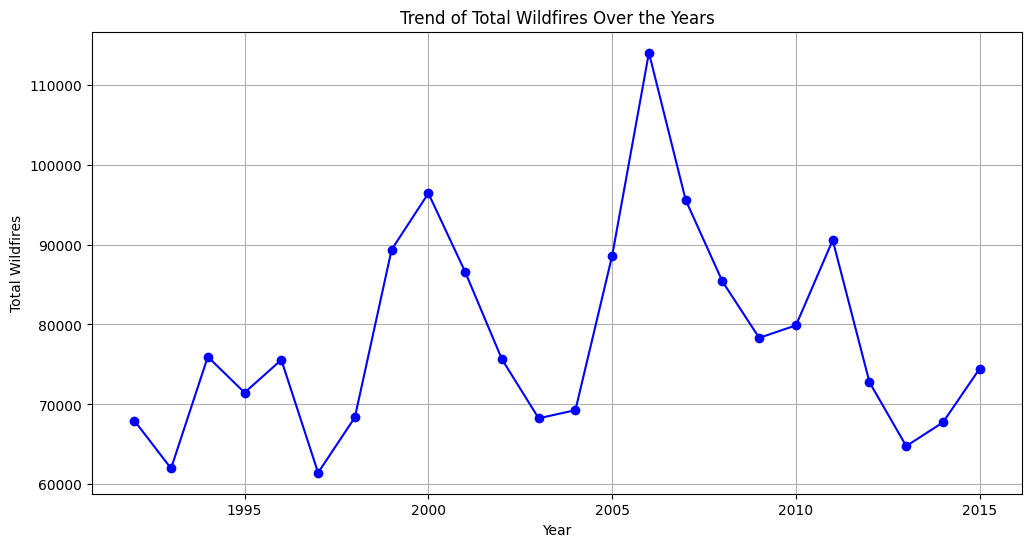

 71%|████████████████████████████████▏            | 5/7 [00:02<00:00,  2.93it/s]15:54:18 - cmdstanpy - INFO - Chain [1] start processing


Execution Output:



15:54:18 - cmdstanpy - INFO - Chain [1] done processing


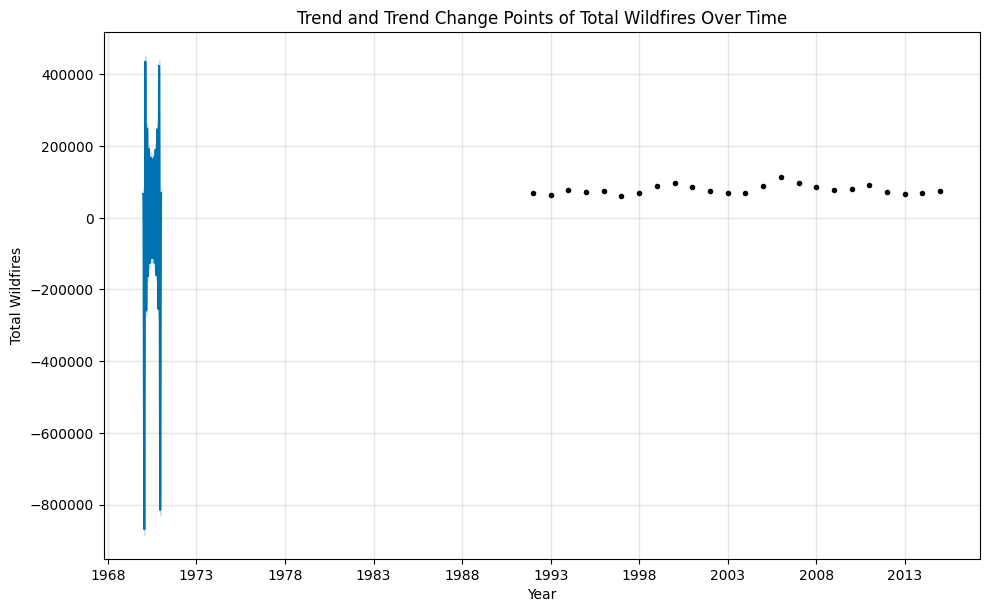

15:54:19 - cmdstanpy - INFO - Chain [1] start processing
15:54:19 - cmdstanpy - INFO - Chain [1] done processing


Execution Output:



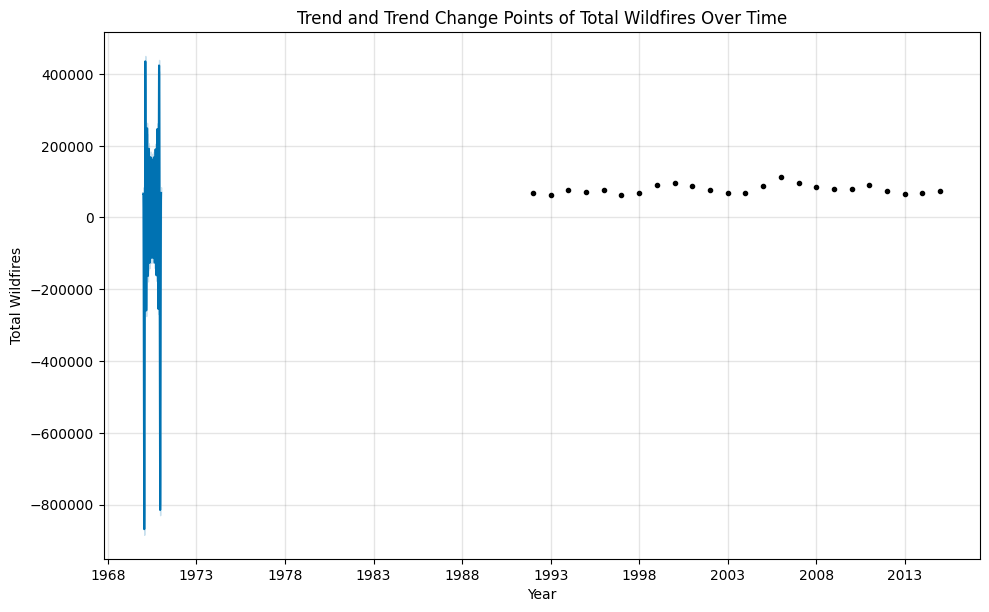

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]

Execution Output:
Wildfires have become more frequent over the analyzed period.



In [72]:
# Step 3: Code execution

from tqdm import tqdm

local_environment = {'df': df_interest}  # Assume df is your DataFrame loaded with the data
for i in tqdm(range(len(tmp))):
    x = tmp[i]
    execution_result = run_code_with_custom_globals(x, local_environment)
    # Output the results
    print("Execution Output:")
    print(execution_result)
    if('Error' in execution_result):
        print(x)

In [ ]:
# Create Label Encoder object
df1['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], format='%m/%d/%Y')
df1['DISCOVERY_DATE'] = df['DISCOVERY_DATE'].dt.strftime('%m%d%Y')

In [ ]:
import sys
import io

def execute_generated_code(generated_code):
    """
    Executes the provided Python code and captures the output.

    Args:
        generated_code (str): Python code to be executed.

    Returns:
        str: Output from executing the code.
    """
    # Backup the current stdout
    old_stdout = sys.stdout
    redirected_output = sys.stdout = io.StringIO()

    try:
        # Execute the generated code
        exec(generated_code, globals())
    except Exception as e:
        # Print any errors encountered during execution
        print(f"Error during execution: {e}")
    finally:
        # Restore the original stdout
        sys.stdout = old_stdout

    # Get the captured output
    output = redirected_output.getvalue()
    redirected_output.close()
    
    return output

# Example usage with generated code
generated_code = """
print(col_txt)
"""
# Execute the generated code and print outputs
output = execute_generated_code(generated_code)
print(output)


In [ ]:



columns = str(df.columns)
memory = [columns]
prompt = '''<s> [INST]You are an agent capable of using a variety of TOOLS to answer a data analytics question.
Always use MEMORY to help select the TOOLS to be used. The name of the SQLlite table is fires.
 
MEMORY
The column names are 
'''
prompt+= columns
prompt+= '''
 
TOOLS
- Generate_Final_Answer: Use if answer to User's question can be given with MEMORY and data we have. Use this after thorough data analysis
- Query_Database: Write only one SQL Query to query the Database. This can only execute one query at a time
 
ANSWER FORMAT
{
    "tool_name": """
    "command": """
}
[/INST]
User:  Have wildfires become more or less frequent over time?
Assistant: {
 "tool_name":
 "command":
}
''' 
messages=[
          {"role": "system", "content": "You are a helpful assistant."},
          {"role": "user", "content": prompt}
]
# Execute the generated SQL query
sql_query = generate_sql_query(messages)
print(sql_query)
print(json.loads(sql_query))
json_query = json.loads(sql_query)

data = run_tool(json_query)

prompt+= sql_query+ "\n ''response:''" + str(data) + "}\n"

messages=[
          {"role": "system", "content": "You are a helpful assistant."},
          {"role": "user", "content": prompt}
]
# messages.append({"role":"system", "content": "SQL data extracted"})
# messages.append({"role":"user", "content": "Move to the next step as specified in the prompt"})
generate_sql_query(messages)




In [ ]:
import re

def extract_sentences_with_numbers(text):
    """
    Extracts sentences from the provided text that contain numbers, ensuring that list items are captured as full sentences.
    
    Args:
        text (str): The input text from which sentences will be extracted.
    
    Returns:
        list: A list of complete sentences containing numbers.
    """
    # Combine multiline list items into single lines and split into sentences
    text = re.sub(r'(\d+)\.\s+', r'\1. ', text)  # Remove newline after numbers for list items
    sentences = re.split(r'[.!?]+', text)
    # Filter sentences that contain any digit and are not just numbers
    sentences_with_numbers = [sentence.strip() for sentence in sentences if re.search(r'\d', sentence) and not sentence.strip().isdigit()]

    return sentences_with_numbers

# Provided plan steps (for demonstration)
plan_steps = """
To predict the cause of a wildfire based on its size, location, and date, follow these steps:

1. Extract the necessary columns from the 'fires' table: FIRE_SIZE, LATITUDE, LONGITUDE, DISCOVERY_DATE, STAT_CAUSE_DESCR.

2. Remove any duplicate rows in the extracted data.

3. Convert the DISCOVERY_DATE column to the required datetime format.

4. Implement the XGBClassifier model to predict the cause of the fire. You can use the following steps:
    - Encode the categorical variable STAT_CAUSE_DESCR using Label Encoder.
    - Split the data into training and testing sets.
    - Fit the XGBClassifier model on the training data.
    - Make predictions on the testing data.
    
5. Generate a ClassificationReport to evaluate the model's performance.

6. If needed, you can also use RandomForestClassifier or other classification models to compare the results.

7. The inverse transform can be used to decode the encoded predicted values back to their original form.

By following these steps, the code generator can execute the necessary operations to predict the cause of a wildfire based on the provided data.
"""

# Extract sentences with numbers
sentences_with_numbers = extract_sentences_with_numbers(plan_steps)
print("Sentences containing numbers:")
for sentence in sentences_with_numbers:
    print(sentence)


In [ ]:
print(plan_steps)

In [ ]:


# Provided text containing steps (summarized for demonstration)
text_with_steps = """
To predict the cause of a wildfire based on size, location, and date, you can follow these steps:

1. Join the 'fires' table with any additional tables containing relevant information on statistical cause codes and descriptions.
2. Filter the dataset to include only the following columns: FIRE_SIZE, LATITUDE, LONGITUDE, DISCOVERY_DATE, STAT_CAUSE_CODE, and STAT_CAUSE_DESCR.
3. Handle missing or null values in the dataset if necessary.
4. Convert the 'DISCOVERY_DATE' column to a format suitable for analysis (e.g., datetime).
5. Use a suitable classification model like RandomForestClassifier or XGBClassifier for prediction.
6. Encode any categorical variables (if needed) using LabelEncoder.
7. Split the dataset into training and testing sets for model training.
8. Train the classification model on the training data.
9. Test the model on the testing data to evaluate its performance.
10. Generate a ClassificationReport to assess the accuracy, precision, recall, and F1 score of the model.
11. Use the model to make predictions on new data points to predict the cause of wildfires based on size, location, and date.

Remember to handle any discrepancies in data types, preprocess the data if necessary, and ensure that the model is trained and tested effectively to provide accurate predictions.
"""

# Extract numbered list items
numbered_list_items = extract_numbered_list_items(plan_steps)
print("Numbered List Items:")
for item in numbered_list_items:
    print(item)
